In [1]:
import palettable
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stat
from statsmodels.stats import multitest
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from lifelines import KaplanMeierFitter
# if running in Colab, import tutorial data
import sys
plt.rcParams["font.family"] = "arial"
from lifelines.statistics import logrank_test

In [3]:
clinical_data = pd.read_csv('TCGA_ClinicalData_Final.csv')
clinical_data

,Study ID,Sample.ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,...,Somatic Status,Staging System,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Tumor Disease Anatomic Site
0,brca_tcga_pub2015,TCGA-A1-A0SK,TCGA-A1-A0SK-01,54.0,M0,N0 (i-),Stage IIA,6th,T2,NaN,...,Matched,Sentinel lymph node biopsy plus axillary disse...,NaN,Other,surgical resection,Lumpectomy,A1,3.366667,NaN,Breast
1,brca_tcga_pub2015,TCGA-A1-A0SP,TCGA-A1-A0SP-01,40.0,M0,N0 (i-),Stage IIA,6th,T2,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Lumpectomy,A1,1.366667,TUMOR FREE,Breast
2,brca_tcga_pub2015,TCGA-A2-A0CM,TCGA-A2-A0CM-01,40.0,M0,N0 (i-),Stage IIA,6th,T2,NaN,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,A2,1.666667,WITH TUMOR,Breast
3,brca_tcga_pub2015,TCGA-A2-A0T0,TCGA-A2-A0T0-01,59.0,M0,N1,Stage IIB,6th,T2,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Lumpectomy,A2,4.800000,TUMOR FREE,Breast
4,brca_tcga_pub2015,TCGA-A2-A0T2,TCGA-A2-A0T2-01,66.0,M1,N3,Stage IV,NaN,T3,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Modified Radical Mastectomy,A2,1.466667,WITH TUMOR,Breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,brca_tcga_pub2015,TCGA-C8-A1HN,TCGA-C8-A1HN-01,56.0,M0,N0,Stage IIA,6th,T2,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Modified Radical Mastectomy,C8,1.266667,TUMOR FREE,Breast
814,brca_tcga_pub2015,TCGA-C8-A26W,TCGA-C8-A26W-01,58.0,M0,N1,Stage IIB,6th,T2,NaN,...,Matched,NaN,NaN,NaN,NaN,Modified Radical Mastectomy,C8,1.400000,TUMOR FREE,Breast
815,brca_tcga_pub2015,TCGA-D8-A1XA,TCGA-D8-A1XA-01,64.0,M0,N0,Stage IA,7th,T1c,% IHC,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,D8,0.766667,TUMOR FREE,Breast
816,brca_tcga_pub2015,TCGA-E2-A105,TCGA-E2-A105-01,79.0,M0,N0 (i-),Stage IIA,6th,T2,Allred score 3 + 2 = 5,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,E2,1.766667,TUMOR FREE,Breast


In [5]:
er_pos_set = clinical_data[clinical_data['ER Status By IHC'] == 'Positive']
er_pos_set

,Study ID,Sample.ID,Sample ID,Diagnosis Age,American Joint Committee on Cancer Metastasis Stage Code,Neoplasm Disease Lymph Node Stage American Joint Committee on Cancer Code,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,American Joint Committee on Cancer Tumor Stage Code,Brachytherapy first reference point administered total dose,...,Somatic Status,Staging System,Staging System.1,Surgery for positive margins,Surgery for positive margins other,Surgical procedure first,Tissue Source Site,TMB (nonsynonymous),Person Neoplasm Status,Tumor Disease Anatomic Site
5,brca_tcga_pub2015,TCGA-A2-A0YF,TCGA-A2-A0YF-01,67.0,M0,N0 (i+),Stage I,6th,T1b,NaN,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Simple Mastectomy,A2,0.566667,TUMOR FREE,Breast
6,brca_tcga_pub2015,TCGA-A2-A0YH,TCGA-A2-A0YH-01,53.0,M0,N2a,Stage IIIA,NaN,T2,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Lumpectomy,A2,2.200000,TUMOR FREE,Breast
7,brca_tcga_pub2015,TCGA-A8-A06N,TCGA-A8-A06N-01,66.0,M0,N0,Stage IIIB,6th,T4b,NaN,...,Matched,NaN,NaN,NaN,NaN,Other,A8,1.133333,TUMOR FREE,Breast
8,brca_tcga_pub2015,TCGA-A8-A07L,TCGA-A8-A07L-01,58.0,M0,N1a,Stage IIIA,6th,T3,NaN,...,Matched,NaN,NaN,NaN,NaN,Other,A8,2.933333,TUMOR FREE,Breast
9,brca_tcga_pub2015,TCGA-A8-A086,TCGA-A8-A086-01,59.0,M0,N1a,Stage IIA,6th,T1c,NaN,...,Matched,NaN,NaN,NaN,NaN,Other,A8,0.600000,TUMOR FREE,Breast
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,brca_tcga_pub2015,TCGA-C8-A1HN,TCGA-C8-A1HN-01,56.0,M0,N0,Stage IIA,6th,T2,NaN,...,Matched,Axillary lymph node dissection alone,NaN,NaN,NaN,Modified Radical Mastectomy,C8,1.266667,TUMOR FREE,Breast
814,brca_tcga_pub2015,TCGA-C8-A26W,TCGA-C8-A26W-01,58.0,M0,N1,Stage IIB,6th,T2,NaN,...,Matched,NaN,NaN,NaN,NaN,Modified Radical Mastectomy,C8,1.400000,TUMOR FREE,Breast
815,brca_tcga_pub2015,TCGA-D8-A1XA,TCGA-D8-A1XA-01,64.0,M0,N0,Stage IA,7th,T1c,% IHC,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,D8,0.766667,TUMOR FREE,Breast
816,brca_tcga_pub2015,TCGA-E2-A105,TCGA-E2-A105-01,79.0,M0,N0 (i-),Stage IIA,6th,T2,Allred score 3 + 2 = 5,...,Matched,Sentinel node biopsy alone,NaN,NaN,NaN,Lumpectomy,E2,1.766667,TUMOR FREE,Breast


In [10]:
er_pos_set_pats = er_pos_set['Sample.ID'].to_list()

In [35]:
kmt2c_muts_from_mutsig = pd.read_csv('/Users/lmartin/Documents/2021/tcga_brca_data/er_pos_all_kmt2c_muts.tsv',sep='\t',index_col=0)
kmt2c_muts_from_mutsig = kmt2c_muts_from_mutsig[kmt2c_muts_from_mutsig['Variant_Classification'] !='Silent']

kmt2c_muts_from_mutsig_labels=list(kmt2c_muts_from_mutsig['Tumor_Sample_Barcode'].unique())

kmt2c_muts_from_mutsig_labels



['TCGA-A1-A0SF',
 'TCGA-A1-A0SI',
 'TCGA-A2-A0CS',
 'TCGA-A2-A0D3',
 'TCGA-A2-A0EM',
 'TCGA-A2-A0EN',
 'TCGA-A2-A0SV',
 'TCGA-A2-A0YT',
 'TCGA-A2-A259',
 'TCGA-A7-A3RF',
 'TCGA-A7-A5ZW',
 'TCGA-A8-A06P',
 'TCGA-A8-A06X',
 'TCGA-A8-A07E',
 'TCGA-A8-A07Z',
 'TCGA-A8-A08P',
 'TCGA-A8-A09Z',
 'TCGA-A8-A0A6',
 'TCGA-AN-A046',
 'TCGA-AN-A0XP',
 'TCGA-AN-A0XV',
 'TCGA-AO-A0JF',
 'TCGA-AO-A125',
 'TCGA-AQ-A1H2',
 'TCGA-AR-A0U2',
 'TCGA-AR-A24N',
 'TCGA-AR-A24S',
 'TCGA-B6-A0IP',
 'TCGA-B6-A0RP',
 'TCGA-B6-A0WV',
 'TCGA-B6-A0X4',
 'TCGA-BH-A0DE',
 'TCGA-BH-A0HQ',
 'TCGA-BH-A18N',
 'TCGA-BH-A1EY',
 'TCGA-C8-A12N',
 'TCGA-C8-A3M7',
 'TCGA-C8-A3M8',
 'TCGA-D8-A1JP',
 'TCGA-D8-A1JT',
 'TCGA-D8-A1X6',
 'TCGA-D8-A27P',
 'TCGA-E2-A1L9',
 'TCGA-E9-A226',
 'TCGA-EW-A1J5',
 'TCGA-EW-A1OY',
 'TCGA-LL-A50Y',
 'TCGA-OL-A5RX',
 'TCGA-OL-A66H']

In [7]:
kmt2c_nonmissense_muts_from_mutsig =kmt2c_muts_from_mutsig[kmt2c_muts_from_mutsig['Variant_Classification'] != 'Missense_Mutation']


kmt2c_nonmissense_muts_from_mutsig = kmt2c_nonmissense_muts_from_mutsig[kmt2c_nonmissense_muts_from_mutsig['Variant_Classification'] !='Silent']
kmt2c_nonmissense_muts_from_mutsig_labels = list(kmt2c_nonmissense_muts_from_mutsig['Tumor_Sample_Barcode'].unique())
kmt2c_nonmissense_muts_from_mutsig


,Tumor_Sample_Barcode,Variant_Classification,Variant_Type,Protein_Change,Reference_Allele,Tumor_Seq_Allele2
39891,TCGA-A2-A0CS,Frame_Shift_Ins,INS,p.I4080fs,-,A
39892,TCGA-A2-A0D3,Frame_Shift_Del,DEL,p.S144fs,G,-
39893,TCGA-A2-A0EM,Frame_Shift_Ins,INS,p.P2436fs,-,G
39894,TCGA-A2-A0EN,Frame_Shift_Del,DEL,p.K3735fs,T,-
39896,TCGA-A2-A0YT,Frame_Shift_Ins,INS,p.S620fs,-,T
39897,TCGA-A2-A259,Nonsense_Mutation,SNP,p.Q109*,G,A
39899,TCGA-A7-A3RF,Nonsense_Mutation,SNP,p.Q1937*,G,A
39902,TCGA-A8-A06P,Splice_Site,SNP,p.P1280P,T,C
39903,TCGA-A8-A06X,In_Frame_Ins,INS,p.3878_3878M>IE,-,TCT
39906,TCGA-A8-A07Z,Frame_Shift_Del,DEL,p.L4157fs,A,-


## load data in from CbioPortal

In [8]:
KMT2C_HOM_MUT = pd.read_csv('TCGA_PanCan_KMT2C_total_loss_v_not_cbioportal/KMT2C_Mut.txt',sep='\t')
KMT2C_HOM_MUT

,Case ID,Study ID,Number at Risk,Status,Survival Rate,Time (months)
0,TCGA-A8-A09Z,brca_tcga_pan_can_atlas_2018,76,censored,1.000000,0.000000
1,TCGA-PL-A8LX,brca_tcga_pan_can_atlas_2018,75,censored,1.000000,0.164382
2,TCGA-AN-A0XP,brca_tcga_pan_can_atlas_2018,74,censored,1.000000,0.295887
3,TCGA-AN-A046,brca_tcga_pan_can_atlas_2018,73,censored,1.000000,0.328764
4,TCGA-AN-A0FW,brca_tcga_pan_can_atlas_2018,72,censored,1.000000,0.361640
...,...,...,...,...,...,...
71,TCGA-A2-A0EM,brca_tcga_pan_can_atlas_2018,5,censored,0.482512,101.719433
72,TCGA-AR-A0TZ,brca_tcga_pan_can_atlas_2018,4,deceased,0.361884,107.242660
73,TCGA-B6-A0IP,brca_tcga_pan_can_atlas_2018,3,deceased,0.241256,129.072558
74,TCGA-A2-A0EN,brca_tcga_pan_can_atlas_2018,2,censored,0.241256,134.398527


In [11]:
KMT2C_WT = pd.read_csv('TCGA_PanCan_KMT2C_total_loss_v_not_cbioportal/KMT2C_WT.txt',sep='\t')
len(KMT2C_WT)

553

In [14]:
KMT2C_WT['Status'].unique()

array(['censored', 'deceased'], dtype=object)

In [17]:
WT_status_list = KMT2C_WT['Status'].to_list()

KMT2C_WT['event'] = [0 if i=='censored' else 1 for i in WT_status_list ]

mut_status_list = KMT2C_HOM_MUT['Status'].to_list()
KMT2C_HOM_MUT['event'] = [0 if i =='censored' else 1 for i in mut_status_list ]

Text(0, 0.5, 'Estimated Probability of Survival')

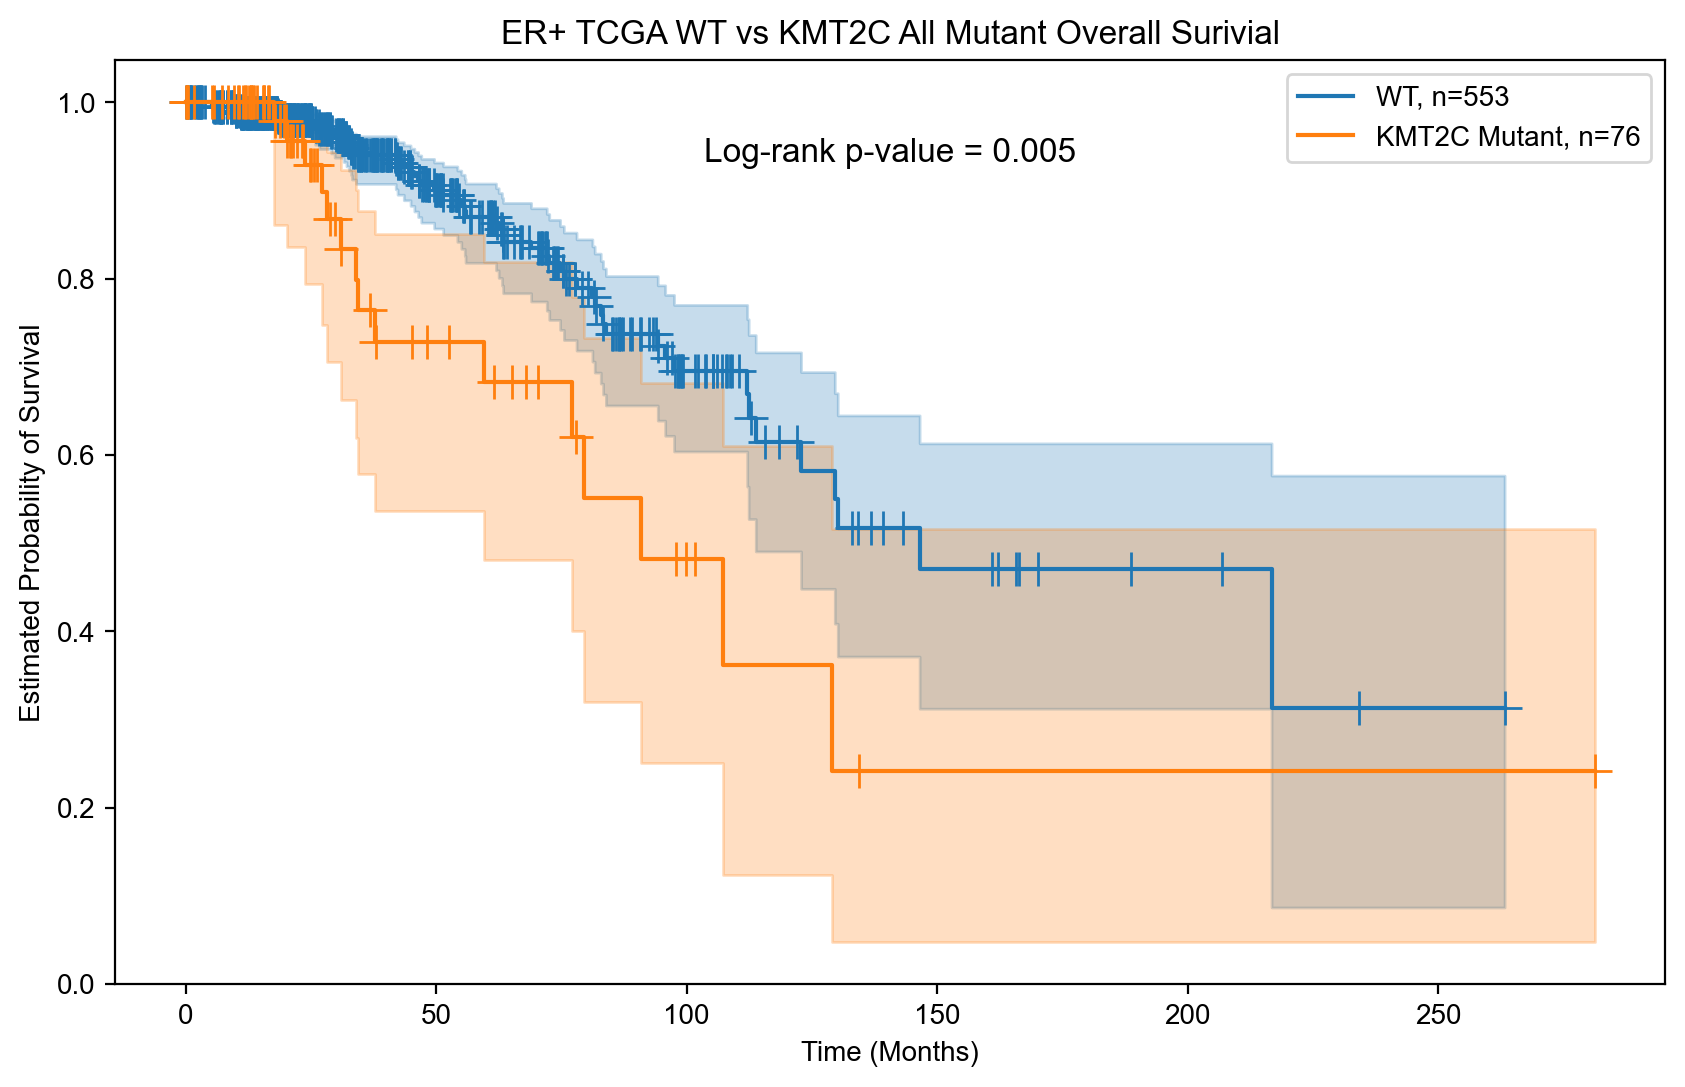

In [25]:

kmf = KaplanMeierFitter()

kmf.fit(KMT2C_WT['Time (months)'],KMT2C_WT['event'], 
        label='WT, n=553')

kmf_kmt2c = KaplanMeierFitter()
kmf_kmt2c.fit(KMT2C_HOM_MUT['Time (months)'],
              KMT2C_HOM_MUT['event'],label="KMT2C Mutant, n=76")


plt.figure(figsize=(10,6))
kmf.plot(show_censors=True)
kmf_kmt2c.plot(show_censors=True)

results = logrank_test(KMT2C_WT['Time (months)'],KMT2C_HOM_MUT['Time (months)'], 
                       KMT2C_WT['event'], KMT2C_HOM_MUT['event'])


plt.text(0.5, 0.9, f'Log-rank p-value = {results.p_value:.3f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.title('ER+ TCGA WT vs KMT2C All Mutant Overall Surivial')
plt.xlabel('Time (Months)')
plt.ylabel('Estimated Probability of Survival')


In [22]:
results = logrank_test(KMT2C_WT['Time (months)'],KMT2C_HOM_MUT['Time (months)'], 
                       KMT2C_WT['event'], KMT2C_HOM_MUT['event'])
results.p_value

0.0051433588874315785

## remove HETLOSS KMT2C

In [29]:
hetloss_kmt2c = pd.read_csv('KMT2C_HETLOSS.txt',sep='\t')
hetloss_kmt2c_samples= hetloss_kmt2c['Case ID']
KMT2C_WT_no_hetloss = KMT2C_WT[~KMT2C_WT['Case ID'].isin(hetloss_kmt2c_samples)]

In [30]:
len(KMT2C_WT_no_hetloss)

457

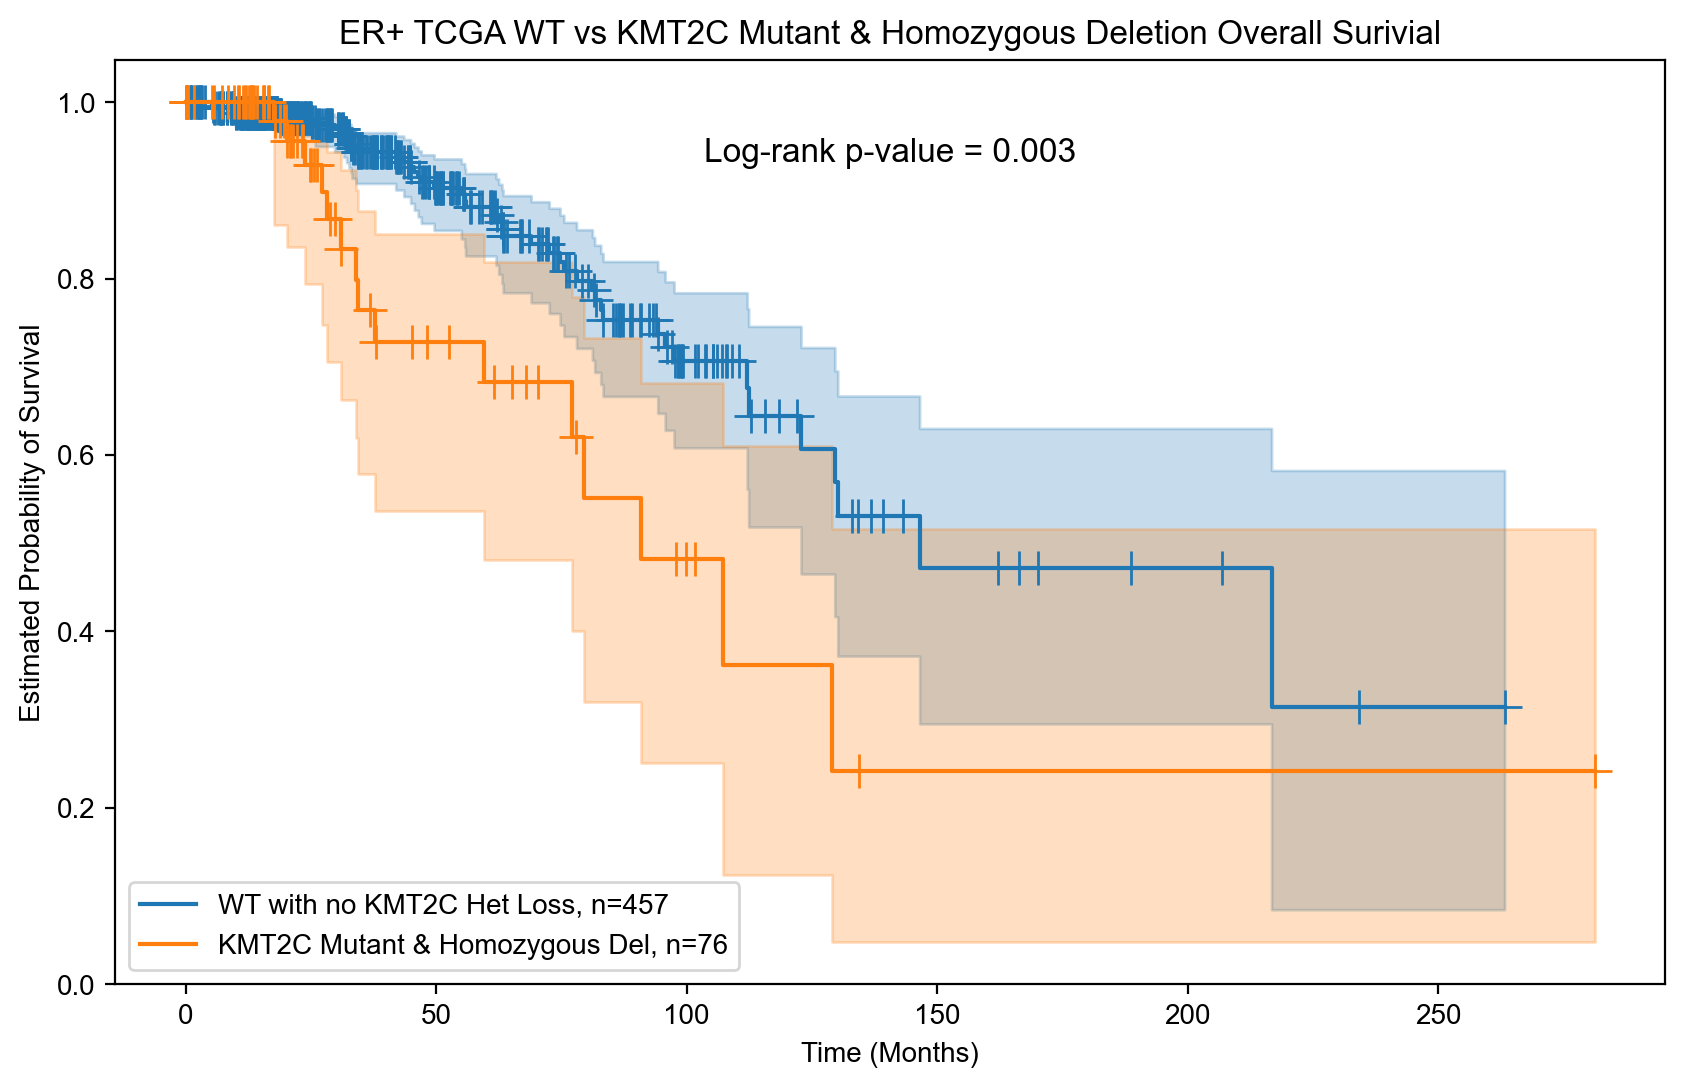

In [36]:

kmf = KaplanMeierFitter()

kmf.fit(KMT2C_WT_no_hetloss['Time (months)'],KMT2C_WT_no_hetloss['event'], 
        label='WT with no KMT2C Het Loss, n=457')

kmf_kmt2c = KaplanMeierFitter()
kmf_kmt2c.fit(KMT2C_HOM_MUT['Time (months)'],
              KMT2C_HOM_MUT['event'],label="KMT2C Mutant & Homozygous Del, n=76")


plt.figure(figsize=(10,6))
kmf.plot(show_censors=True)
kmf_kmt2c.plot(show_censors=True)

results = logrank_test(KMT2C_WT_no_hetloss['Time (months)'],KMT2C_HOM_MUT['Time (months)'], 
                       KMT2C_WT_no_hetloss['event'], KMT2C_HOM_MUT['event'])


plt.text(0.5, 0.9, f'Log-rank p-value = {results.p_value:.3f}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

plt.title('ER+ TCGA WT vs KMT2C Mutant & Homozygous Deletion Overall Surivial')
plt.xlabel('Time (Months)')
plt.ylabel('Estimated Probability of Survival')

plt.savefig('KMT2C_mut_vs_WT_removed_hetloss_KM_curve.svg')

In [33]:
results.p_value

0.003492018152264371